# PyTorch Implementation of SNGP

The core concepts of **Spectral-nroamalised Neural Gaussian Process** (SNGP) can be found in the original paper https://arxiv.org/abs/2006.10108. SNGP's main idea is to improve the ability of deep neural networks to retain distance information and to leverage this to determine the distance between test examples and the training data to improve predictive uncertainty estimates. 

This notebook roughly follows the outline of https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb but aims to implement all functionality shown here in PyTorch.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from collections import namedtuple
NetResult = namedtuple('NetResult', ('mean', 'variance'))


Define visualization macros

In [3]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the trainining and evaluation datasets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [4]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [5]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training.

In [6]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

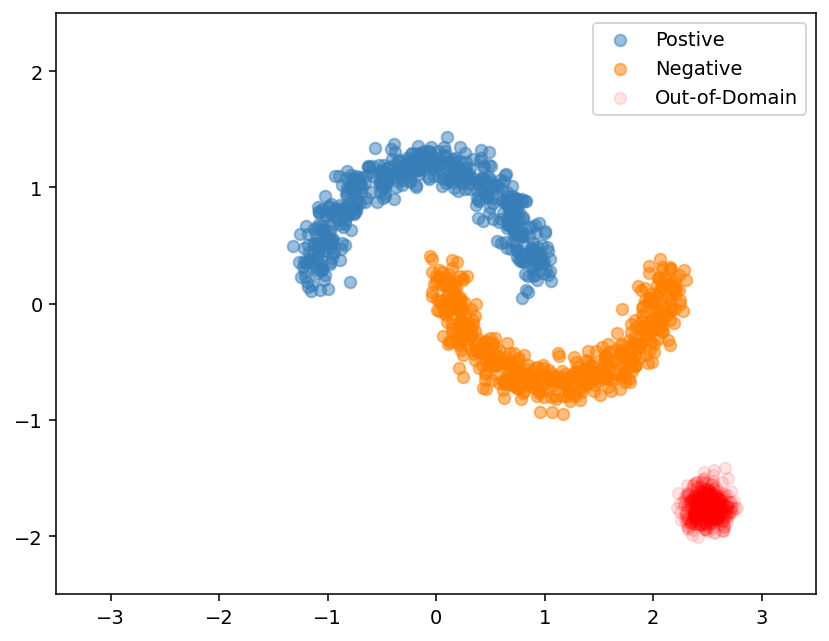

In [7]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

In [8]:
from torch.utils.data import Dataset, DataLoader
class TrainDataset(Dataset):
  def __init__(self):
    self.train_examples = torch.from_numpy(train_examples).type(torch.FloatTensor)
    self.train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)
    # print(self.train_examples, train_examples)
    print(type(self.train_examples), type(self.train_labels))

  def __len__(self):
    return len(self.train_examples)
  
  def __getitem__(self, idx):
    return self.train_examples[idx], self.train_labels[idx]

In [9]:
TrainDataset()

<class 'torch.Tensor'> <class 'torch.Tensor'>


Here the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## The deterministic model

### Define model

Start from the (baseline) deterministic model: a multi-layer residual network (ResNet) with dropout regularization.

In [10]:
import torch.nn as nn

class DeepResNet(nn.Module):
  def __init__(self, num_classes, input_features=2, num_hidden_layers=1, num_hidden=128, dropout_rate=0.1):
    super().__init__()
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.input_layer = nn.Linear(in_features=input_features, out_features=num_hidden)
    self.hidden_layers = nn.Sequential(*[nn.Linear(in_features=num_hidden, out_features=num_hidden) for _ in range(num_hidden_layers)])
    self.dropout_layers = nn.Sequential(*[nn.Dropout(p=dropout_rate) for _ in range(num_hidden_layers)])
    self.classifier = nn.Linear(in_features=num_hidden, out_features=num_classes)

  def forward(self, input):
    input = self.input_layer(input)
    for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
      residual = input
      input = F.relu(hidden_layer(input))
      input = dropout_layer(input)
      input = input + residual
    input = self.classifier(input)
    return NetResult(mean=input, variance=None) 


### Train model

Configure the training parameters to use `CrossEntropyLoss` as the loss function and the Adam optimizer.

In [11]:
import torch.optim as optim
resnet_config = dict(num_classes=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1)
resnet_model = DeepResNet(**resnet_config)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-3)
resnet_model


DeepResNet(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout_layers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Dropout(p=0.1, inplace=False)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [12]:
training_set = TrainDataset()
training_config = dict(batch_size=128, shuffle=True)
training_loader = DataLoader(training_set, **training_config)
training_set, training_loader

<class 'torch.Tensor'> <class 'torch.Tensor'>


(<__main__.TrainDataset at 0x7f44a26579d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4392697a10>)

In [13]:
def train_epoch(epoch_index, model, loss_fn):
  running_loss = 0.

  for i, (inputs, labels) in enumerate(training_loader):
    optimizer.zero_grad()
    outputs = model(inputs).mean
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    # print(running_loss)
    # print(i, inputs.shape, labels.shape)
    
  return running_loss / (i+1) 



In [14]:
def training_loop(model, loss_fn, epochs=100):
  torch.autograd.set_detect_anomaly(True)
  model.train()

  for epoch in range(epochs):
      model.train(True)
      loss = train_epoch(epoch, model, loss_fn)
      if epoch % 10 == 0:
        print(f'Epoch: {epoch}/{epochs}, Loss: {loss}')
      # can do validation loss below


In [15]:
training_loop(model=resnet_model, loss_fn=loss_fn)

Epoch: 0/100, Loss: 0.31727405171841383
Epoch: 10/100, Loss: 0.0034936461379402317
Epoch: 20/100, Loss: 0.0002322900863873656
Epoch: 30/100, Loss: 0.0002403769200327588
Epoch: 40/100, Loss: 0.00019984902394298842
Epoch: 50/100, Loss: 3.6486618000708404e-05
Epoch: 60/100, Loss: 0.0006812216937532867
Epoch: 70/100, Loss: 0.0005742578041463275
Epoch: 80/100, Loss: 2.369767611298812e-05
Epoch: 90/100, Loss: 2.1992987626617833e-05


### Visualize uncertainty

In [16]:
# See https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb#scrollTo=HZDMX7gZrZ-5 for original implementation
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

Now visualize the predictions of the deterministic model. First plot the class probability: 
$$p(x) = softmax(logit(x))$$

In [17]:
resnet_logits = resnet_model(torch.Tensor(test_examples)).mean.detach()
resnet_probs = F.softmax(resnet_logits, dim=1).numpy()[:, 0]
resnet_probs

array([1.        , 1.        , 1.        , ..., 0.9999943 , 0.99851984,
       0.9999099 ], dtype=float32)

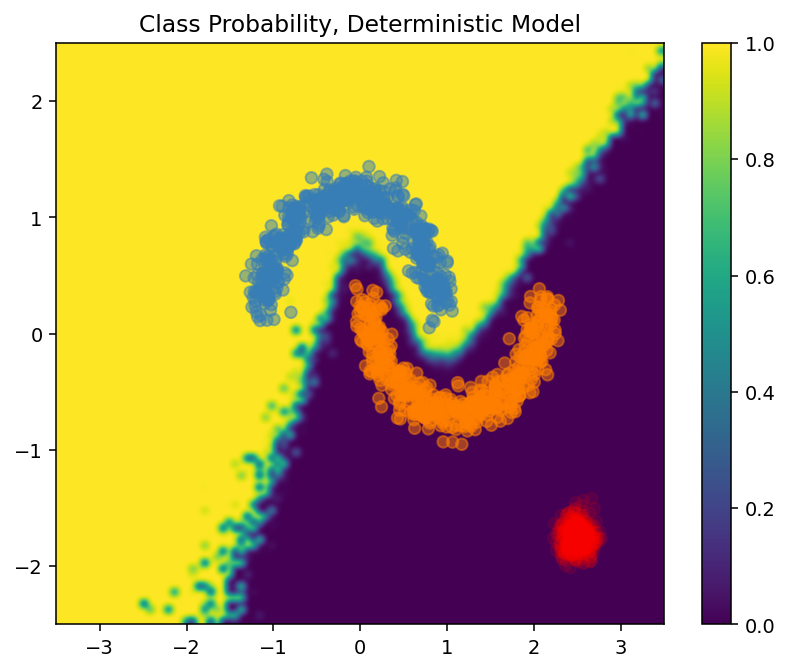

In [18]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In [19]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

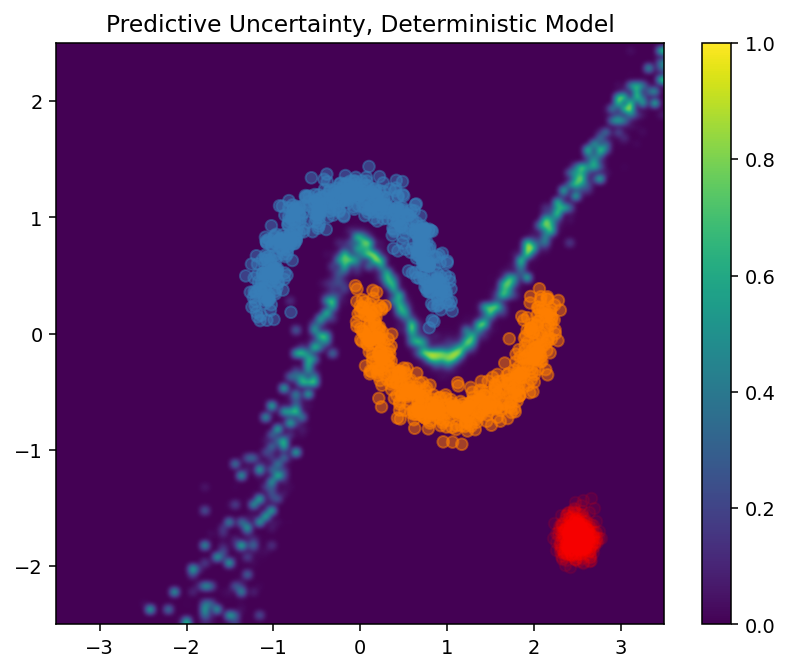

In [20]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

In this plot, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

The SNGP model should preserve distance from the training data and we can leverage this for better predictive uncertainty estimation.

SNGP requires SpectralNormalisation at the input layer which we will achieve using PyTorch's `torch.nn.utils.parametrizations.spectral_norm`. We can apply this to a linear layer fairly straightforwardly. Taken from https://pytorch.org/docs/stable/generated/torch.nn.utils.parametrizations.spectral_norm.html#torch.nn.utils.parametrizations.spectral_norm:

#### Spectral Normalization

In [21]:
snm = nn.utils.parametrizations.spectral_norm(nn.Linear(20, 40), n_power_iterations=2)
snm

ParametrizedLinear(
  in_features=20, out_features=40, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): _SpectralNorm()
    )
  )
)

In [22]:
torch.linalg.matrix_norm(snm.weight, 2)

tensor(1.0005, grad_fn=<CopyBackwards>)

#### The Gaussian Process (GP)

PyTorch currently lacks a Random-Feature Based Approximation to gaussian process model module unlike Tensorflow. I have decided to implement this myself below.

In [23]:
def print_shapes(vars):
  for var, var_name in vars:
    print(f'{var_name} has shape {var.shape}')


In [24]:
import torch.nn as nn
import torch
import math

# Approximates the gaussian prior (placed after the final hidden layer)
# Nothing needs to be tuned in this module
class RandomFourierFeature(nn.Module):
  def __init__(self, in_features, out_features, output_scale=None):
    super().__init__()
    self.weight = torch.empty(in_features, out_features, requires_grad=False)
    self.bias = torch.empty(out_features, requires_grad=False)
    # Initialised based on https://arxiv.org/pdf/2006.10108.pdf
    # D_L = out_features
    nn.init.normal_(self.weight)
    nn.init.uniform_(self.bias, a=0, b=2*torch.pi)
    self.output_scale = output_scale or math.sqrt(2/out_features)
  
  def forward(self, input):
    output = input @ self.weight + self.bias
    return self.output_scale * torch.cos(output)

# Approximates the posterior distribution over the gaussian process
class LaplancePosterior(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    # Initialising beta using normal distribution has been omitted
    self.beta = nn.Linear(in_features=in_features, out_features=out_features, bias=False)
    nn.init.normal_(self.beta.weight)

  def forward(self, input):
    output = self.beta(input)
    return output 

In [25]:
class SNGP(nn.Module):
  def __init__(self, 
               num_classes, 
               input_features=2, 
               num_hidden_layers=1, 
               num_hidden=128, 
               dropout_rate=0.1, 
               momentum=0.999, 
               ridge_penalty=1e-6,
               num_inducing=1024):
    
    super().__init__()
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.input_layer = nn.utils.spectral_norm(nn.Linear(in_features=input_features, out_features=num_hidden))
    self.hidden_layers = nn.Sequential(*[nn.utils.spectral_norm(nn.Linear(in_features=num_hidden, out_features=num_hidden)) for _ in range(num_hidden_layers)])
    # self.dropout_layers = nn.Sequential(*[nn.Dropout(p=dropout_rate) for _ in range(num_hidden_layers)])
    self.random_fourier_feature = RandomFourierFeature(in_features=num_hidden, out_features=num_inducing)
    self.laplace_posterior_linear = LaplancePosterior(in_features=num_inducing, out_features=num_classes)
    self.momentum = momentum 
    self.precision_matrix = ridge_penalty * torch.eye(num_inducing, requires_grad=False)

  def forward(self, input, update_precision_matrix=True):
    input = self.input_layer(input)

    # Standard residual neural network with dropout
    for hidden_layer in self.hidden_layers:
      residual = input
      input = F.relu(hidden_layer(input))
      # input = dropout_layer(input)
      input = input + residual

    # Approximation of gaussian process prior on final hidden layer. 
    # Implementation details are based on https://arxiv.org/pdf/2006.10108.pdf 
    random_fourier_feature = self.random_fourier_feature(input)
    output = self.laplace_posterior_linear(random_fourier_feature)

    if update_precision_matrix:     
      self.update_feature_precision_matrix(random_fourier_feature=random_fourier_feature, output_logits=output)
      assert self.precision_matrix.shape[0] == self.precision_matrix.shape[1]

    if not self.training:
      # Compute predictive covariance in inference mode in addition to logits
      variance = self.compute_predictive_variance(random_fourier_feature)
      return NetResult(mean=output, variance=variance)

    return NetResult(mean=output, variance=None)
  
  def compute_predictive_variance(self, gp_feature):
    feature_cov_matrix = torch.inverse(self.precision_matrix)
    # TODO: work on caching this for repeated inference so long as feature matrix
    # is unchanged
    cov_feature_product = torch.matmul(feature_cov_matrix, gp_feature.t())
    gp_cov_matrix = torch.matmul(gp_feature, cov_feature_product)
    return gp_cov_matrix


  def update_feature_precision_matrix(self, random_fourier_feature, output_logits):
    batch_size = int(random_fourier_feature.shape[0])
    # D_L x D_L <= p * (1 - p)
    # batch_size x D_L <= kernel_cov_matrix
    prob = torch.sigmoid(output_logits)
    prob_multiplier = prob * (1. - prob)
    adjusted_feature = torch.matmul(torch.sqrt(prob_multiplier).t(), random_fourier_feature)
    precision_matrix_minibatch = torch.matmul(adjusted_feature.t(), adjusted_feature)

    if self.momentum and self.momentum > 0:
      precision_matrix_minibatch = precision_matrix_minibatch / batch_size
      self.precision_matrix = (self.momentum * self.precision_matrix) + ((1. - self.momentum) * precision_matrix_minibatch)
    else:
      # Only call once population wise if momentum is None or < 0
      self.precision_matrix = self.precision_matrix + precision_matrix_minibatch



In [26]:
import torch.optim as optim
sngp_config = dict(num_classes=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1)
sngp_model = SNGP(**sngp_config)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(sngp_model.parameters(), lr=1e-3)
sngp_model

SNGP(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
  )
  (random_fourier_feature): RandomFourierFeature()
  (laplace_posterior_linear): LaplancePosterior(
    (beta): Linear(in_features=1024, out_features=2, bias=False)
  )
)

In [27]:
training_loop(sngp_model, loss_fn, epochs=100)

Epoch: 0/100, Loss: 0.42295143101364374
Epoch: 10/100, Loss: 0.0015023713785922155
Epoch: 20/100, Loss: 0.0007663719952688552
Epoch: 30/100, Loss: 0.0006429775276046712
Epoch: 40/100, Loss: 0.0005289859036565758
Epoch: 50/100, Loss: 0.00034041724757116754
Epoch: 60/100, Loss: 0.0002443832090648357
Epoch: 70/100, Loss: 0.00021692044356314
Epoch: 80/100, Loss: 0.00021036775251559447
Epoch: 90/100, Loss: 0.0001809590621633106


In [28]:
sngp_model.eval()
sngp_logits, sngp_covmat = sngp_model(torch.Tensor(test_examples))
sngp_variance = torch.diag(sngp_covmat.detach())[:, None]

In [29]:
sngp_variance.shape, sngp_logits.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

Computing the posterior predictive probability. We could use Monte Carlo sampling but this requires multiple inferences and removes the latency benefits of SNGP over using ensembles or MC dropout to estimate predictive uncertainty. Instead, we approximate $E(p(x))$ using the mean-field method:

$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt(1 + \lambda \sigma^2(x))})$

where often $\lambda$ is chosen as $\pi/8$ or $3/\pi^2$.

In [36]:
sngp_logits_adjusted = sngp_logits.detach() / torch.sqrt(1. + ((torch.pi / 8.) * sngp_variance))
sngp_probs = F.softmax(sngp_logits_adjusted, dim=1).numpy()[:, 0]

sngp_probs.shape

(10000,)

In [37]:
sngp_probs = F.softmax(sngp_logits, dim=1).detach().numpy()[:, 0]

In [38]:
sngp_probs[:20]

array([0.66295594, 0.6627629 , 0.66001254, 0.65626884, 0.6536177 ,
       0.65855914, 0.66654915, 0.6776033 , 0.691707  , 0.7100507 ,
       0.73027176, 0.75326765, 0.77532166, 0.7947148 , 0.81207234,
       0.82716715, 0.8369251 , 0.843337  , 0.8478206 , 0.84946156],
      dtype=float32)

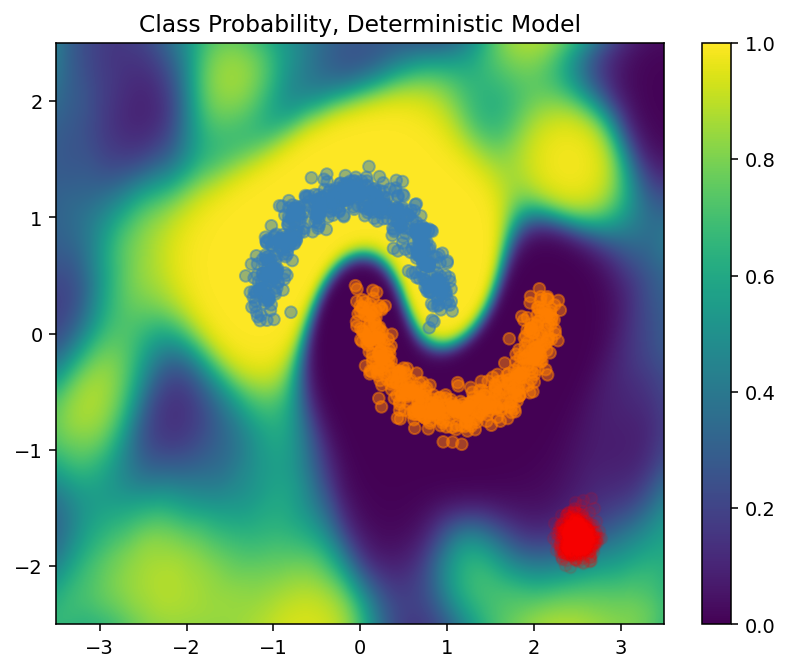

In [39]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(sngp_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In [40]:
sngp_uncertainty = sngp_probs * (1-sngp_probs)

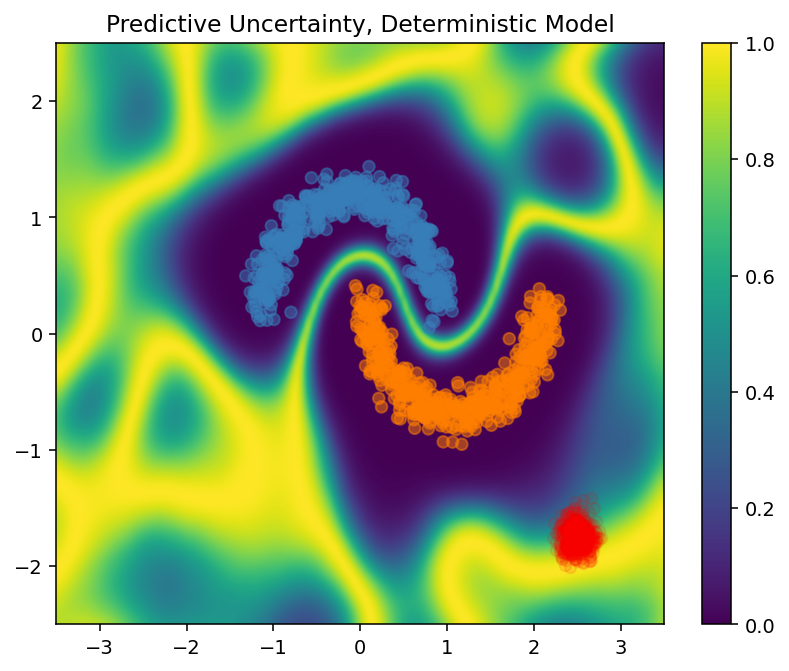

In [41]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(sngp_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()